In [1]:
import torch
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

**Dataset and Dataloader**

In [3]:
import sys
from torch.utils.data import random_split
sys.path.append('../')  # Adjust the path accordingly
from VQA_Dataset import VQA_Dataset

dataset = VQA_Dataset()
dataset.load_all(preprocess=None, length=400, device=device)

train_size = int(len(dataset)*0.8)
val_size = int(len(dataset)*0.1)
test_size = int(len(dataset))-train_size-val_size
generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)

# Dataloader 
batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Preprocessing Images: 100%|██████████| 400/400 [00:11<00:00, 34.99it/s]


Train size:  320
Test size:  40


c:\Users\Zetans\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


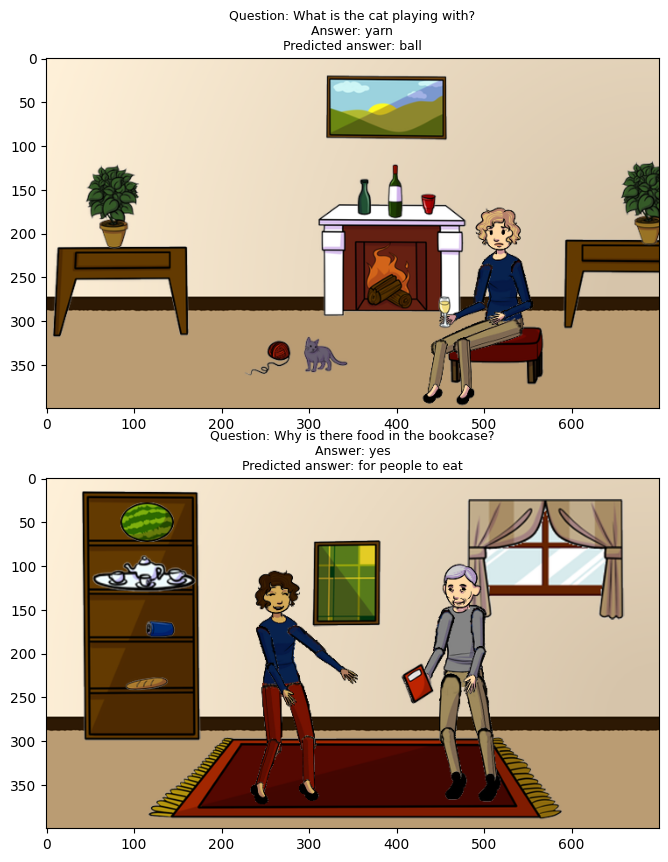

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

#Checking data
fig=plt.figure(0, (28, 10))
for element in train_dataloader:
    for i in range(batch_size):
        ax = fig.add_subplot(2,int(batch_size/2),i+1)
        img_tensor = element["image"][i].squeeze(0)
        
        transform = transforms.ToPILImage()
        img_pil = transform(img_tensor)
        question = str(element["question"][i])

        # array_possible_answers = np.array(element["possible_answers"], dtype=object).T
        # # Define a list of letters
        # letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']
        
        # # Create a prompt for BLIP
        # result_string = ''
        # for j, a in enumerate(array_possible_answers[i]):
        #     result_string += f'{letters[j]}) {a} '
        # print(result_string)

        #prompt = f"Question: {question}, {result_string}, Correct answer:"
        #print(prompt)
        
        inputs = processor(images=img_pil, text=question, return_tensors="pt")
        outputs = model.generate(**inputs)

        
        predicted_answer = processor.decode(outputs[0], skip_special_tokens=True)
        
        ax.imshow(np.transpose(element["image"][i].squeeze(0).cpu(), (1, 2, 0))) #Converting to matplotlib format
        ax.set_title("Question: "+question+"\nAnswer: "+str(element["correct_answer_text"][i])+"\nPredicted answer: "+predicted_answer, fontsize=9)
    break

**Evaluating model without training**

In [6]:
import tqdm
#Evaluating raw model
def eval(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for data in pbar:             
            img_tensors = data["image"].squeeze(1)
            transform = transforms.ToPILImage()
            imgs_pil = [transform(img_tensor) for img_tensor in img_tensors]
            questions = data["question"]
            inputs = processor(images=imgs_pil, text=questions, return_tensors="pt", padding=True)
            
            outputs = model.generate(**inputs)

            predicted_answers = processor.batch_decode(outputs, skip_special_tokens=True)
            print(predicted_answers)
            correct_answers = data["correct_answer_text"]
            
            correct += sum(pred_answer == correct_answer for pred_answer, correct_answer in zip(predicted_answers, correct_answers))
            #print(predicted_answers, correct_answers)
            #print(correct)
            break
                
    correct /= size
    return 100*correct

eval(train_dataloader, model) #50.9375%

  0%|          | 0/160 [00:00<?, ?it/s]

{'pixel_values': tensor([[[[1.9303, 1.9303, 1.9303,  ..., 1.5216, 1.5216, 1.5216],
          [1.9303, 1.9303, 1.9303,  ..., 1.5216, 1.5216, 1.5216],
          [1.9303, 1.9303, 1.9303,  ..., 1.5216, 1.5216, 1.5216],
          ...,
          [0.9230, 0.9230, 0.9230,  ..., 0.9230, 0.9230, 0.9230],
          [0.9230, 0.9230, 0.9230,  ..., 0.9230, 0.9230, 0.9230],
          [0.9230, 0.9230, 0.9230,  ..., 0.9230, 0.9230, 0.9230]],

         [[1.8648, 1.8648, 1.8648,  ..., 1.3995, 1.3995, 1.3995],
          [1.8648, 1.8648, 1.8648,  ..., 1.3995, 1.3995, 1.3995],
          [1.8648, 1.8648, 1.8648,  ..., 1.3995, 1.3995, 1.3995],
          ...,
          [0.5891, 0.5891, 0.5891,  ..., 0.5891, 0.5891, 0.5891],
          [0.5891, 0.5891, 0.5891,  ..., 0.5891, 0.5891, 0.5891],
          [0.5891, 0.5891, 0.5891,  ..., 0.5891, 0.5891, 0.5891]],

         [[1.6055, 1.6055, 1.6055,  ..., 1.1505, 1.1505, 1.1505],
          [1.6055, 1.6055, 1.6055,  ..., 1.1363, 1.1363, 1.1363],
          [1.6055, 1.6055

c:\Users\Zetans\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  0%|          | 0/160 [00:10<?, ?it/s]


0.0

**Transfer learning for Multiple choice VQA**

1. Bleu score as a help for blip

In [8]:
from nltk.translate.bleu_score import sentence_bleu #n-gran: series of n tokens
import numpy as np

reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
print("1-gram", sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))) # 3/4
print("2-gram", sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))) # 1/3
print("3-gram", sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))) # 0

bp=np.exp(1-4/4) #Brevity penalty: candidate is not longer than reference, then formula
cum_2_gram = bp*np.exp(0.5*np.log(3/4)+0.5*np.log(1/3))
print("Cumulative 2-gram", sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)), " Manually: ", cum_2_gram)

#More references
reference = [['this', 'is', 'small', 'test'], ['this', 'small', 'test', 'a']]
candidate = ['this', 'is', 'a', 'test']
print("1-gram", sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))) # 4/4
print("2-gram", sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))) # 1/3
print("3-gram", sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))) # 0

bp=1 #Brevity penalty: reference is not longer than candidate, then 1
cum_2_gram = bp*np.exp(0.5*np.log(4/4)+0.5*np.log(1/3))
print("Cumulative 2-gram", sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)), " Manually: ", cum_2_gram)

#Larger reference
reference = [['this', 'is', 'small', 'test','jaja']]
candidate = ['this', 'is', 'a', 'test']
print("1-gram", sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))) # 3/4*exp(1-5/4)
print("2-gram", sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))) # 1/3*exp(1-5/4)
print("3-gram", sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))) # 0

bp=np.exp(1-5/4) #Brevity penalty: reference is longer than candidate, then formula
cum_2_gram = bp*np.exp(0.5*np.log(3/4)+0.5*np.log(1/3))
print("Cumulative 2-gram", sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)), " Manually: ", cum_2_gram)

#Larger candidate
reference = [['this', 'is', 'small']]
candidate = ['this', 'is', 'a', 'test']
print("1-gram", sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))) # 2/4*1
print("2-gram", sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))) # 1/3*1
print("3-gram", sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))) # 0

bp=1 #Brevity penalty: reference is not longer than candidate, then 1
cum_2_gram = bp*np.exp(0.5*np.log(2/4)+0.5*np.log(1/3))
print("Cumulative 2-gram", sentence_bleu(reference, candidate, weights=[(0.5, 0.5, 0, 0)]), " Manually: ", cum_2_gram)

1-gram 0.75
2-gram 0.3333333333333333
3-gram 2.2250738585072626e-308
Cumulative 2-gram 0.49999999999999994  Manually:  0.49999999999999994
1-gram 1.0
2-gram 0.3333333333333333
3-gram 2.2250738585072626e-308
Cumulative 2-gram 0.5773502691896257  Manually:  0.5773502691896257
1-gram 0.5841005873035536
2-gram 0.2596002610238016
3-gram 1.7328892633971685e-308
Cumulative 2-gram 0.3894003915357024  Manually:  0.3894003915357024
1-gram 0.5
2-gram 0.3333333333333333
3-gram 2.2250738585072626e-308
Cumulative 2-gram 0.408248290463863  Manually:  0.408248290463863


c:\Users\Zetans\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zetans\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')
class ModelPlusBLEU(torch.nn.Module):
    def __init__(self, model, device):
        super().__init__()
        self.model = model
        self.device = device

    def forward(self, inputs, multiple_answers):
        blip_output = model.generate(**inputs)
        candidate_answers = processor.batch_decode(blip_output, skip_special_tokens=True)
        multiple_answers_batch = multiple_answers
        predicted_answers = []

        for candidate_answer, multiple_answers in zip(candidate_answers, multiple_answers_batch):
            num_words_candidate = len(candidate_answer.split(" "))
            weights = ([1.0/num_words_candidate]*num_words_candidate)
            
            bleu_scores=[]
            for answer in multiple_answers:
                answer_tokens = [nltk.tokenize.word_tokenize(answer)]
                candidate_answer_tokens = nltk.tokenize.word_tokenize(candidate_answer)
                bleu_scores.append(sentence_bleu(answer_tokens, candidate_answer_tokens, weights=weights))
            print(bleu_scores)
            #bleu_scores = np.ndarray([sentence_bleu([nltk.tokenize.word_tokenize(answer)], nltk.tokenize.word_tokenize(candidate_answer), weights=weights) ])    
            if [0]*18!=bleu_scores:
                predicted_answers.append(multiple_answers[np.argmax(bleu_scores)])
            else:
                predicted_answers.append(None)
        #print(candidate_answers, predicted_answers)
        return predicted_answers
#modelBleu = ModelPlusBLEU(model, device)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zetans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zetans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index


In [10]:
import tqdm
#Evaluating raw model
def eval(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for data in pbar:             
            img_tensors = data["image"].squeeze(1)
            transform = transforms.ToPILImage()
            imgs_pil = [transform(img_tensor) for img_tensor in img_tensors]
            questions = data["question"]
            inputs = processor(images=imgs_pil, text=questions, return_tensors="pt", padding=True)
            possible_answers = np.array(data["possible_answers"], dtype=object).T
            predicted_answers = modelBleu(inputs, possible_answers)
            correct_answers = data["correct_answer_text"]            
            
            correct += sum(pred_answer == correct_answer for pred_answer, correct_answer in zip(predicted_answers, correct_answers))
            #print(predicted_answers, correct_answers)
            #print(correct)
                
    correct /= size
    return 100*correct

#eval(train_dataloader, modelBleu) #53.75%

**Fine-tuning on abstract dataset**